<a href="https://colab.research.google.com/github/C8XY66/GNN/blob/main/GIN_Optuna_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
!pip install pytorch-lightning

In [ ]:
!pip install git+https://github.com/optuna/optuna.git
!pip install optuna-dashboard

In [ ]:
import os.path as osp
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


import logging
#logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger('lightning').setLevel(0)

import torch
import torch.nn.functional as F
from torchmetrics import Accuracy

import torch_geometric.transforms as T
from torch_geometric.data.lightning import LightningDataset
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GIN, MLP, global_add_pool

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization.matplotlib import plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice


Mounted at /content/gdrive


In [ ]:
DIR = "/content/gdrive/My Drive/ColabNotebooks/" 

# Check for CUDA system support and use GPU if available otherwise run on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device = Context-manager that changes the selected device
print(device)

cuda


In [ ]:
# Hyperparameters

dataset_name = 'NCI1'
num_layers = 5
lr = 0.01 
epochs = 500 #final = 1000
SEED = 42

In [ ]:
class Model(pl.LightningModule):
    def __init__(self, in_channels: int, out_channels: int,
                 hidden_channels: int, dropout, num_layers=num_layers):
        super().__init__()
        self.gnn = GIN(in_channels, hidden_channels, num_layers,
                       dropout=dropout, jk='cat')

        self.classifier = MLP([hidden_channels, hidden_channels, out_channels],
                              norm="batch_norm", dropout=dropout)

        self.train_acc = Accuracy(task='multiclass', num_classes=out_channels)
        self.val_acc = Accuracy(task='multiclass', num_classes=out_channels)
        self.test_acc = Accuracy(task='multiclass', num_classes=out_channels)

    def forward(self, x, edge_index, batch):
        x = self.gnn(x, edge_index)
        x = global_add_pool(x, batch)
        x = self.classifier(x)
        return x

    def training_step(self, data, batch_idx):
        y_hat = self(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(y_hat, data.y)
        self.train_acc(y_hat.softmax(dim=-1), data.y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, data, batch_idx):
        y_hat = self(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(y_hat, data.y)
        self.val_acc(y_hat.softmax(dim=-1), data.y)
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, data, batch_idx):
        y_hat = self(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(y_hat, data.y)
        self.test_acc(y_hat.softmax(dim=-1), data.y)
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_acc', self.test_acc, prog_bar=True, on_step=False,on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)


In [ ]:
class GraphDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, num_workers=0, stage=None, split="train"):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.stage = stage
        self.split = split

    def setup(self, stage: Optional[str] = None):
        dataset = TUDataset(root='data/TUDataset', name=dataset_name)
        dataset.shuffle()
        #dataset = dataset[:500] #for quick experiments

        if stage == "fit":
          if self.split == "selection":
            self.val_dataset = dataset[:len(dataset)//10] # 0%-10%
            self.train_dataset = dataset[len(dataset)//10:] # 10%-100
          elif self.split == "assessment":
            self.val_dataset = dataset[len(dataset)//10: 2*len(dataset)//10] # 10%-20%
            self.train_dataset = dataset[2*len(dataset)//10:] # 20%-100

        if stage == "test":
          self.test_dataset = dataset[:len(dataset)//10] # 0%-10%
        
        self.dataset = dataset
      
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    @property
    def num_node_features(self):
        return self.dataset.num_node_features

    @property
    def num_classes(self):
        return self.dataset.num_classes


In [ ]:
class GraphDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, n_splits=10, fold=0):
        super().__init__()
        self.batch_size = batch_size
        self.n_splits = n_splits
        self.fold = fold
        

    def setup(self, stage: Optional[str] = None):
        skf = StratifiedKFold(n_splits=self.n_splits)
        
        dataset = TUDataset(root='data/TUDataset', name=dataset_name)
        targets = dataset.data.y.numpy()
        #dataset = dataset[:500] #for quick experiments

        # For experiments with dummy nodes
        #for i in range(len(dataset)):
        #    dataset[i] = self.neutralize_node_features(dataset[i])

        train_indices, val_indices = list(skf.split(range(len(targets)), targets))[self.fold]
        self.train_dataset = dataset[train_indices]
        self.val_dataset = dataset[val_indices]

        self.dataset = dataset
      
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    @property
    def num_node_features(self):
        return self.dataset.num_node_features

    @property
    def num_classes(self):
        return self.dataset.num_classes

    def neutralize_node_features(data):
        num_nodes = data.x.size(0)
        data.x = torch.zeros(num_nodes, 1)
        data.x[:, 0] = 1
        return data

In [ ]:
def objective(trial): 

    # Optimise hyperparameters
    hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32])
    batch_size = trial.suggest_categorical('batch_size', [32, 128])
    dropout = trial.suggest_categorical('dropout', [0.0, 0.5])

    
    datamodule = GraphDataModule(batch_size=batch_size, split="selection")
    datamodule.setup()

    model = Model(in_channels=datamodule.num_node_features, out_channels=datamodule.num_classes, hidden_channels=hidden_channels, dropout=dropout)

    pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_acc") #from optuna-pl-integration
    early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=True) #final patience = 500 for acc and loss
    #checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc', save_top_k=1, mode='max')
    
    trainer = pl.Trainer(
        default_root_dir=DIR,
        callbacks=[pruning_callback, early_stopping], 
        max_epochs=epochs,
        log_every_n_steps=5, 
        logger=TensorBoardLogger(save_dir=DIR),
        enable_progress_bar=False,
    )


    hyperparameters = dict(hidden_channels=hidden_channels, batch_size=batch_size, epochs=epochs, dropout=dropout)
    trainer.logger.log_hyperparams(hyperparameters)    
    
    trainer.fit(model, datamodule=datamodule)
    
    # Print training and validation accuracies and losses 
    train_acc = trainer.callback_metrics['train_acc']
    train_loss = trainer.callback_metrics['train_loss']
    val_acc = trainer.callback_metrics['val_acc']
    val_loss = trainer.callback_metrics['val_loss']
    print(f"Trial: {trial.number}, Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}\n")

    return trainer.callback_metrics['val_acc'].item()
    

[I 2023-04-17 12:50:20,503] A new study created in memory with name: no-name-2461abdd-1cc9-40d7-bb1d-6fb25be01fac
[I 2023-04-17 12:50:36,518] Trial 0 finished with value: 0.6374695897102356 and parameters: {'hidden_channels': 32, 'batch_size': 32, 'dropout': 0.0}. Best is trial 0 with value: 0.6374695897102356.


Trial: 0, Train Accuracy: 0.7034, Train Loss: 0.5609, Val Accuracy: 0.6375, Val Loss: 0.6693



[I 2023-04-17 12:50:43,851] Trial 1 finished with value: 0.6715328693389893 and parameters: {'hidden_channels': 32, 'batch_size': 128, 'dropout': 0.5}. Best is trial 1 with value: 0.6715328693389893.


Trial: 1, Train Accuracy: 0.7137, Train Loss: 0.5667, Val Accuracy: 0.6715, Val Loss: 0.6118



[I 2023-04-17 12:50:52,519] Trial 2 finished with value: 0.46715328097343445 and parameters: {'hidden_channels': 16, 'batch_size': 128, 'dropout': 0.5}. Best is trial 1 with value: 0.6715328693389893.


Trial: 2, Train Accuracy: 0.7080, Train Loss: 0.5691, Val Accuracy: 0.4672, Val Loss: 0.7601



[I 2023-04-17 12:51:19,351] Trial 3 finished with value: 0.4841849207878113 and parameters: {'hidden_channels': 16, 'batch_size': 32, 'dropout': 0.5}. Best is trial 1 with value: 0.6715328693389893.


Trial: 3, Train Accuracy: 0.7002, Train Loss: 0.5766, Val Accuracy: 0.4842, Val Loss: 0.8138



[I 2023-04-17 12:51:25,030] Trial 4 finished with value: 0.40145984292030334 and parameters: {'hidden_channels': 32, 'batch_size': 128, 'dropout': 0.0}. Best is trial 1 with value: 0.6715328693389893.


Trial: 4, Train Accuracy: 0.7251, Train Loss: 0.5448, Val Accuracy: 0.4015, Val Loss: 0.9456



[I 2023-04-17 12:51:35,575] Trial 5 finished with value: 0.5425790548324585 and parameters: {'hidden_channels': 16, 'batch_size': 128, 'dropout': 0.0}. Best is trial 1 with value: 0.6715328693389893.


Trial: 5, Train Accuracy: 0.7288, Train Loss: 0.5348, Val Accuracy: 0.5426, Val Loss: 0.8159



[I 2023-04-17 12:51:37,297] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2023-04-17 12:51:38,198] Trial 7 pruned. Trial was pruned at epoch 0.
<ipython-input-75-24d81ea672da>:25: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
<ipython-input-75-24d81ea672da>:26: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(study)
<ipython-input-75-24d81ea672da>:27: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2023-04-17 12:51:38,258] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.



Number of finished trials: 8
Number of Complete trials:  6
Number of Pruned trials:  2
Pruned trials:
  Trial 6: 0.3893
  Trial 7: 0.1995

Best trial: 1
  Value: 0.6715328693389893
  Params: 
    hidden_channels: 32
    batch_size: 128
    dropout: 0.5


<ipython-input-75-24d81ea672da>:28: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


Train Accuracy: 0.7281, Train Loss: 0.5374, Val Accuracy: 0.6886, Val Loss: 0.6191



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6763990521430969     │
│         test_loss         │    0.5995016694068909     │
└───────────────────────────┴───────────────────────────┘


Test set results:
Test accuracy: 0.6764   Test loss: 0.5995



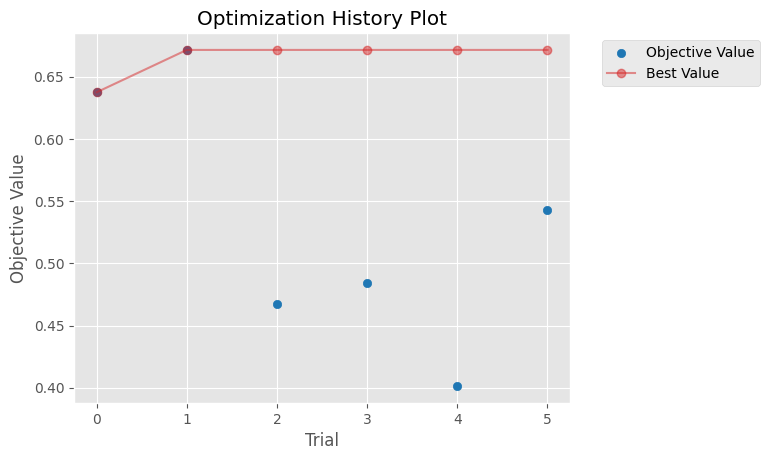

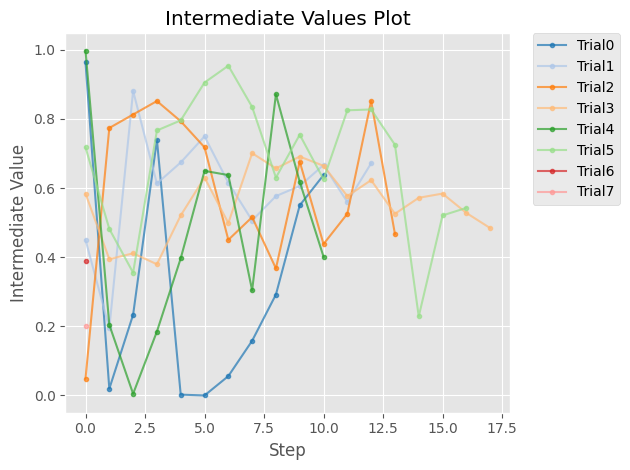

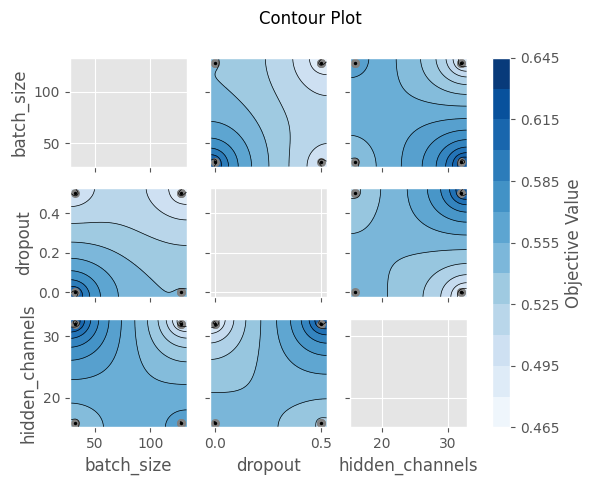

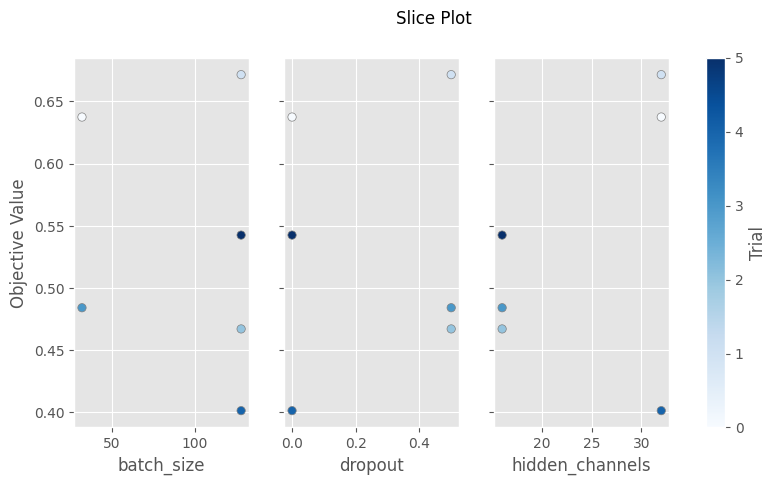

In [ ]:
if __name__ == '__main__':

    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler(seed=SEED),)

    study.optimize(objective, n_trials=8, timeout=600) 

    pruned_trials = study.get_trials(states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(states=[optuna.trial.TrialState.COMPLETE])
    
    print("\nNumber of finished trials: {}".format(len(study.trials)))
    print("Number of Complete trials: ", len(complete_trials))
    print("Number of Pruned trials: ", len(pruned_trials))
    print("Pruned trials:")
    for trial in pruned_trials:
      print(f"  Trial {trial.number}: {trial.value:.4f}") 

    trial = study.best_trial
    
    print(f"\nBest trial: {trial.number}")
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    plot_optimization_history(study)
    plot_intermediate_values(study)
    plot_contour(study)
    plot_slice(study)
    
    best_hyperparams = study.best_params

    # Create a new GraphDataModule and Model with the best hyperparameters
    test_datamodule = GraphDataModule(batch_size=best_hyperparams["batch_size"], split = "assessment")
    test_datamodule.setup()
    test_model = Model(in_channels=test_datamodule.num_node_features, 
                       out_channels=test_datamodule.num_classes, 
                       hidden_channels=best_hyperparams["hidden_channels"], 
                       dropout=best_hyperparams["dropout"])

    # Train the model on the combined train and validate set
    early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=True) 
   
    trainer = pl.Trainer(max_epochs=epochs,
                         default_root_dir=DIR,
                         callbacks=[early_stopping], 
                         logger=TensorBoardLogger(save_dir=DIR),
                         log_every_n_steps=5, 
                         enable_progress_bar=False)
        
    trainer.fit(test_model,  datamodule=test_datamodule)

    train_acc = trainer.callback_metrics['train_acc']
    train_loss = trainer.callback_metrics['train_loss']
    val_acc = trainer.callback_metrics['val_acc']
    val_loss = trainer.callback_metrics['val_loss']
    print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}\n")
  
       
    # Evaluate the model on the test set
    trainer.test(test_model, datamodule=test_datamodule)

    test_acc = trainer.callback_metrics['test_acc']
    test_loss = trainer.callback_metrics['test_loss']

    # Print results for test set
    print(f"\nTest set results:")
    print(f"Test accuracy: {test_acc:.4f}   Test loss: {test_loss:.4f}\n")

